In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from ad99py.loon import loon_data

In [2]:
LOON_DATA= loon_data()


In [3]:
ds_data = xr.open_dataset('/scratch/users/robcking/era5_coarse.zarr',chunks={})
net_flux = ds_data.sel(level=70).gw_flux_negative + ds_data.sel(level=70).gw_flux_positive
net_flux = net_flux.persist()


ValueError: found the following matches with the input file in xarray's IO backends: ['zarr']. But their dependencies may not be installed, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

mima

In [4]:
ds_mima = xr.open_dataset('data/mima_ref_ad99_atmosdaily0.nc')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/robcking/PhD/ad99py/notebooks/data/mima_ref_ad99_atmosdaily0.nc'

In [5]:
net_mima = np.abs(ds_mima.uw_ntv + ds_mima.uw_ptv)
net_mima_lvl = net_mima.sel(pfull=70,method='nearest').data.ravel()*1000
net_mima_lvl = net_mima_lvl[net_mima_lvl > 0 ]

mask

In [6]:
ds_mask_trop = xr.open_dataset('data/loon_masks.nc')

ds_mask_trop['lon'] = (ds_mask_trop.lon + 360) % 360 
ds_mask_trop = ds_mask_trop.sortby('lon')
ds_mask_trop = ds_mask_trop.rename(lat='latitude',lon='longitude')
interp_mask = ds_mask_trop.interp(latitude=ds_data.latitude,longitude=ds_data.longitude,method='nearest').astype(bool)
total_mask = sum(interp_mask[d] for d in interp_mask.data_vars)

In [7]:
net_flux_points = net_flux.where(total_mask).stack(points = ['latitude','longitude'])
net_flux_points = net_flux_points.dropna('points',how='all')


In [8]:
net_flux_points_initial =  net_flux_points.data.ravel().compute()

total

Text(0, 0.5, 'Probability Density')

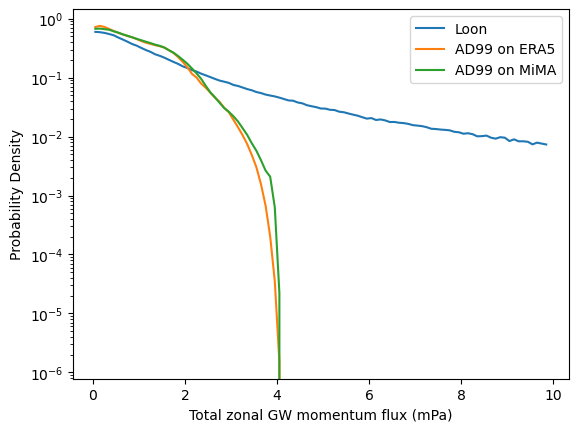

In [9]:
bins = np.arange(0,10,0.1)
loonval,_ = np.histogram(np.abs(LOON_DATA['u_flux_net']),bins=bins,density=True)
eraval, _ = np.histogram(1000*np.abs(net_flux_points_initial),bins=bins,density=True)
mimaval, _ = np.histogram(net_mima_lvl,bins=bins,density=True)
bin_c = (bins[1:] + bins[:-1])*0.5
plt.plot(bin_c,loonval,label='Loon')
plt.plot(bin_c,eraval,label='AD99 on ERA5')
plt.plot(bin_c,mimaval,label='AD99 on MiMA')
plt.yscale('log')
plt.legend()
plt.xlabel("Total zonal GW momentum flux (mPa)")
plt.ylabel("Probability Density")

/tmp/ipykernel_244327/35528711.py:4: RuntimeWarning: divide by zero encountered in log10
  eraval, _ = np.histogram(np.log10(1000*np.abs(net_flux_points_initial)),bins=bins,density=True)


Text(0, 0.5, 'Probability Density')

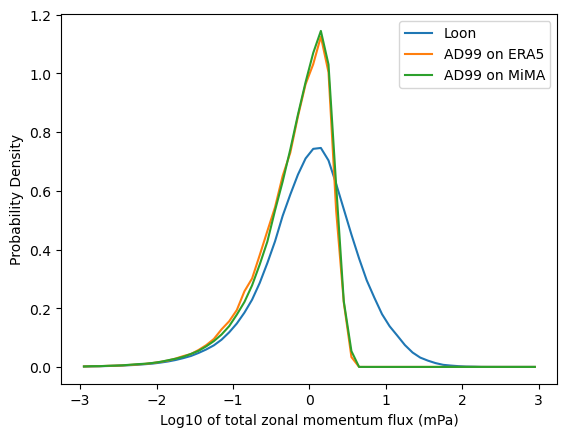

In [10]:
bins = np.arange(-3,3+0.1,0.1)

loonval,_ = np.histogram(np.log10(np.abs(LOON_DATA['u_flux_net'])),bins=bins,density=True)
eraval, _ = np.histogram(np.log10(1000*np.abs(net_flux_points_initial)),bins=bins,density=True)
mimaval, _ = np.histogram(np.log10(net_mima_lvl),bins=bins,density=True)
bin_c = (bins[1:] + bins[:-1])*0.5
plt.plot(bin_c,loonval,label='Loon')
plt.plot(bin_c,eraval,label='AD99 on ERA5')
plt.plot(bin_c,mimaval,label='AD99 on MiMA')
plt.legend()
plt.xlabel("Log10 of total zonal momentum flux (mPa)")
plt.ylabel("Probability Density")

positive

In [11]:
ptv_flux = ds_data.sel(level=70).gw_flux_positive

ptv_flux = ptv_flux.where(total_mask).stack(points = ['latitude','longitude'])
ptv_flux = ptv_flux.dropna('points',how='all')
ptv_flux = ptv_flux.data.ravel().compute()
ptv_flux = ptv_flux[ptv_flux>0]*1000

In [12]:
mima_ptv_flux = np.abs(ds_mima.uw_ptv)
mima_ptv_flux = mima_ptv_flux.sel(pfull=70,method='nearest').data.ravel()*1000
mima_ptv_flux = mima_ptv_flux[mima_ptv_flux > 0 ]

Text(0, 0.5, 'Probability Density')

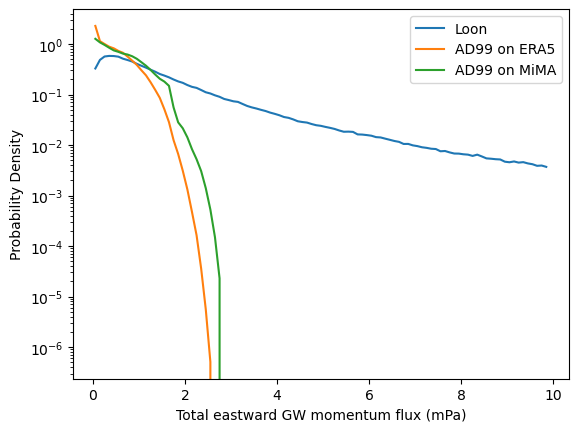

In [13]:
bins = np.arange(0,10,0.1)
loonval,_ = np.histogram(np.abs(LOON_DATA['u_flux_ptv']),bins=bins,density=True)
eraval, _ = np.histogram(np.abs(ptv_flux),bins=bins,density=True)
mimaval, _ = np.histogram(mima_ptv_flux,bins=bins,density=True)
bin_c = (bins[1:] + bins[:-1])*0.5
plt.plot(bin_c,loonval,label='Loon')
plt.plot(bin_c,eraval,label='AD99 on ERA5')
plt.plot(bin_c,mimaval,label='AD99 on MiMA')

plt.yscale('log')
plt.legend()
plt.xlabel("Total eastward GW momentum flux (mPa)")
plt.ylabel("Probability Density")

/tmp/ipykernel_244327/1220434504.py:3: RuntimeWarning: divide by zero encountered in log10
  loonval,loon_edge = np.histogram(np.log10(LOON_DATA['u_flux_ptv']),bins=bins,density=True)


Text(0, 0.5, 'Probability Density')

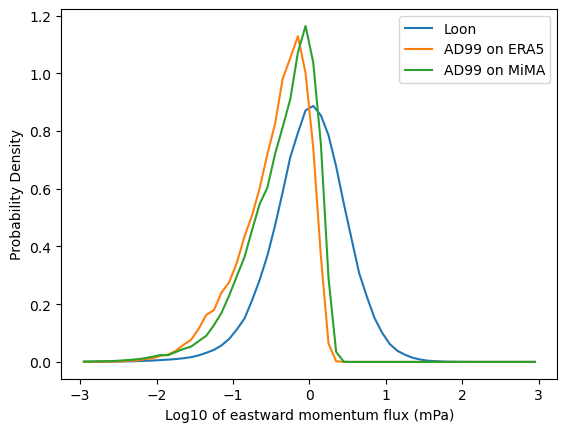

In [14]:
bins = np.arange(-3,3+0.1,0.1)

loonval,loon_edge = np.histogram(np.log10(LOON_DATA['u_flux_ptv']),bins=bins,density=True)
eraval, _ = np.histogram(np.log10(np.abs(ptv_flux)),bins=bins,density=True)
mimaval, _ = np.histogram(np.log10(mima_ptv_flux),bins=bins,density=True)
bin_c = (bins[1:] + bins[:-1])*0.5

plt.plot(bin_c,loonval,label="Loon")
plt.plot(bin_c,eraval,label='AD99 on ERA5')
plt.plot(bin_c,mimaval,label='AD99 on MiMA')
plt.legend()
plt.xlabel("Log10 of eastward momentum flux (mPa)")
plt.ylabel("Probability Density")

ntv

In [15]:
ntv_flux = ds_data.sel(level=70).gw_flux_negative

ntv_flux = ntv_flux.where(total_mask).stack(points = ['latitude','longitude'])
ntv_flux = ntv_flux.dropna('points',how='all')
ntv_flux = ntv_flux.data.ravel().compute()
ntv_flux = ntv_flux[ntv_flux<0]*1000

mima_ntv_flux = np.abs(ds_mima.uw_ntv)
mima_ntv_flux = mima_ntv_flux.sel(pfull=70,method='nearest').data.ravel()*1000
mima_ntv_flux = mima_ntv_flux[mima_ntv_flux > 0 ]

Text(0, 0.5, 'Probability Density')

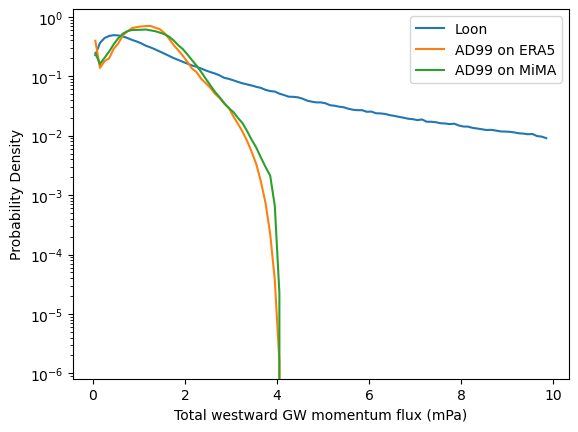

In [16]:
bins = np.arange(0,10,0.1)
loonval,_ = np.histogram(np.abs(LOON_DATA['u_flux_ntv']),bins=bins,density=True)
eraval, _ = np.histogram(np.abs(ntv_flux),bins=bins,density=True)
mimaval, _ = np.histogram(mima_ntv_flux,bins=bins,density=True)
bin_c = (bins[1:] + bins[:-1])*0.5
plt.plot(bin_c,loonval,label='Loon')
plt.plot(bin_c,eraval,label='AD99 on ERA5')
plt.plot(bin_c,mimaval,label='AD99 on MiMA')

plt.yscale('log')
plt.legend()
plt.xlabel("Total westward GW momentum flux (mPa)")
plt.ylabel("Probability Density")

/tmp/ipykernel_244327/3096922826.py:3: RuntimeWarning: divide by zero encountered in log10
  loonval,loon_edge = np.histogram(np.log10(np.abs(LOON_DATA['u_flux_ntv'])),bins=bins,density=True)


Text(0, 0.5, 'Probability Density')

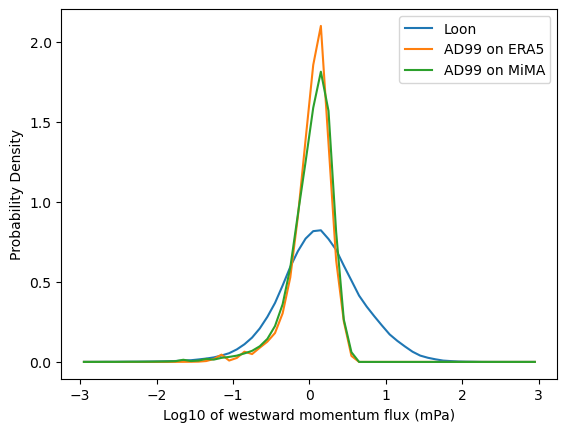

In [17]:
bins = np.arange(-3,3+0.1,0.1)

loonval,loon_edge = np.histogram(np.log10(np.abs(LOON_DATA['u_flux_ntv'])),bins=bins,density=True)
eraval, _ = np.histogram(np.log10(np.abs(ntv_flux)),bins=bins,density=True)
mimaval, _ = np.histogram(np.log10(mima_ntv_flux),bins=bins,density=True)
bin_c = (bins[1:] + bins[:-1])*0.5

plt.plot(bin_c,loonval,label="Loon")
plt.plot(bin_c,eraval,label='AD99 on ERA5')
plt.plot(bin_c,mimaval,label='AD99 on MiMA')
plt.legend()
plt.xlabel("Log10 of westward momentum flux (mPa)")
plt.ylabel("Probability Density")

abs

In [18]:
abs_flux = np.abs(ds_data.sel(level=70).gw_flux_negative) + np.abs(ds_data.sel(level=70).gw_flux_positive)

abs_flux = abs_flux.where(total_mask).stack(points = ['latitude','longitude'])
abs_flux = abs_flux.dropna('points',how='all')
abs_flux = abs_flux.data.ravel().compute()
abs_flux = abs_flux[abs_flux>0]*1000

mima_abs_flux = np.abs(ds_mima.uw_ntv) + np.abs(ds_mima.uw_ptv)
mima_abs_flux = mima_abs_flux.sel(pfull=70,method='nearest').data.ravel()*1000
mima_abs_flux = mima_abs_flux[mima_abs_flux > 0 ]

Text(0, 0.5, 'Probability Density')

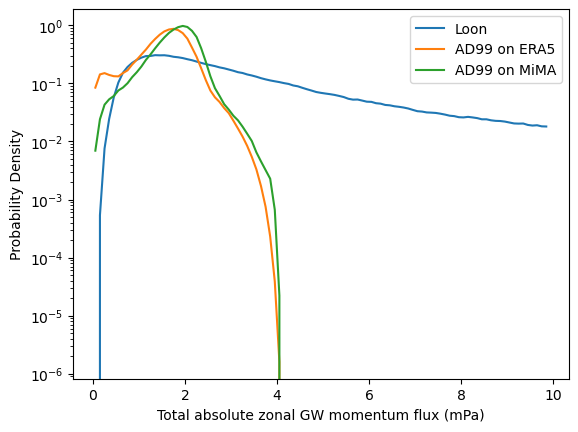

In [23]:
bins = np.arange(0,10,0.1)
loonval,_ = np.histogram(np.abs(LOON_DATA['u_flux_abs']),bins=bins,density=True)
eraval, _ = np.histogram(np.abs(abs_flux),bins=bins,density=True)
mimaval, _ = np.histogram(mima_abs_flux,bins=bins,density=True)
bin_c = (bins[1:] + bins[:-1])*0.5
plt.plot(bin_c,loonval,label='Loon')
plt.plot(bin_c,eraval,label='AD99 on ERA5')
plt.plot(bin_c,mimaval,label='AD99 on MiMA')

plt.yscale('log')
plt.legend()
plt.xlabel("Total absolute zonal GW momentum flux (mPa)")
plt.ylabel("Probability Density")

Text(0, 0.5, 'Probability Density')

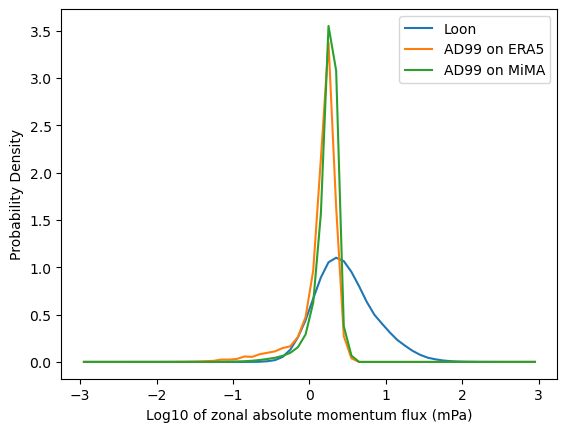

In [22]:
bins = np.arange(-3,3+0.1,0.1)

loonval,loon_edge = np.histogram(np.log10(np.abs(LOON_DATA['u_flux_abs'])),bins=bins,density=True)
eraval, _ = np.histogram(np.log10(np.abs(abs_flux)),bins=bins,density=True)
mimaval, _ = np.histogram(np.log10(mima_abs_flux),bins=bins,density=True)
bin_c = (bins[1:] + bins[:-1])*0.5

plt.plot(bin_c,loonval,label="Loon")
plt.plot(bin_c,eraval,label='AD99 on ERA5')
plt.plot(bin_c,mimaval,label='AD99 on MiMA')
plt.legend()
plt.xlabel("Log10 of zonal absolute momentum flux (mPa)")
plt.ylabel("Probability Density")

## more log normal higher up?

In [38]:
net_flux = ds_data.sel(level=2).gw_flux_negative + ds_data.sel(level=2).gw_flux_positive
net_flux = net_flux.persist()

net_flux_points = net_flux.where(total_mask).stack(points = ['latitude','longitude'])
net_flux_points = net_flux_points.dropna('points',how='all')
net_flux_points = 1000*net_flux_points.data.ravel().compute()


net_mima = np.abs(ds_mima.uw_ntv + ds_mima.uw_ptv)
net_mima_lvl = net_mima.sel(pfull=2,method='nearest').data.ravel()*1000
net_mima_lvl = net_mima_lvl[net_mima_lvl > 0 ]

Text(0, 0.5, 'Probability Density')

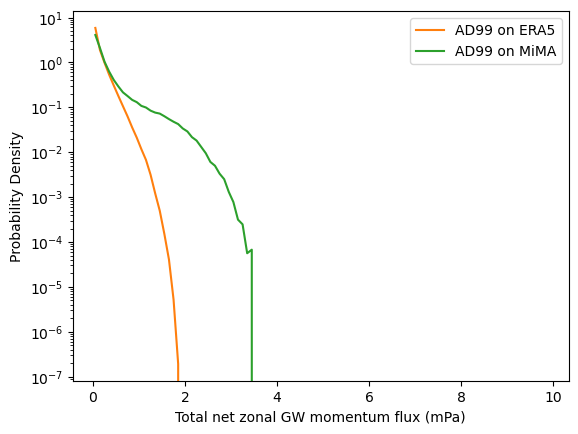

In [41]:
bins = np.arange(0,10,0.1)
eraval, _ = np.histogram(net_flux_points,bins=bins,density=True)
mimaval, _ = np.histogram(net_mima_lvl,bins=bins,density=True)
bin_c = (bins[1:] + bins[:-1])*0.5
plt.plot(bin_c,eraval,label='AD99 on ERA5',color='C1')
plt.plot(bin_c,mimaval,label='AD99 on MiMA',color='C2')
plt.yscale('log')
plt.legend()
plt.xlabel("Total net zonal GW momentum flux (mPa)")
plt.ylabel("Probability Density")

/tmp/ipykernel_244327/3380311115.py:5: RuntimeWarning: divide by zero encountered in log10
  eraval, _ = np.histogram(np.log10(np.abs(net_flux_points)),bins=bins,density=True)


Text(0, 0.5, 'Probability Density')

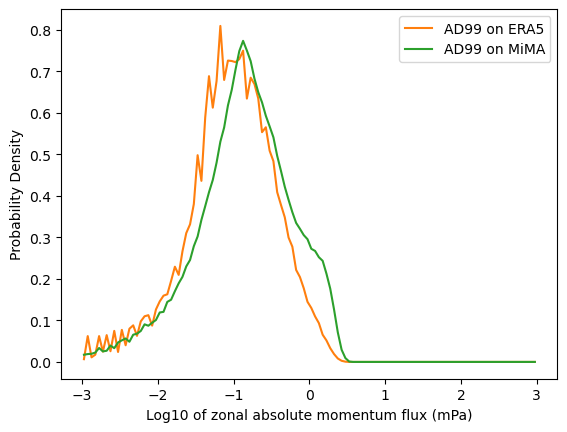

In [44]:
dc = 0.05
bins = np.arange(-3,3+dc,dc)

# loonval,loon_edge = np.histogram(np.log10(np.abs(LOON_DATA['u_flux_abs'])),bins=bins,density=True)
eraval, _ = np.histogram(np.log10(np.abs(net_flux_points)),bins=bins,density=True)
mimaval, _ = np.histogram(np.log10(net_mima_lvl),bins=bins,density=True)
bin_c = (bins[1:] + bins[:-1])*0.5

# plt.plot(bin_c,loonval,label="Loon")
plt.plot(bin_c,eraval,label='AD99 on ERA5',color='C1')
plt.plot(bin_c,mimaval,label='AD99 on MiMA',color='C2')
plt.legend()
plt.xlabel("Log10 of zonal absolute momentum flux (mPa)")
plt.ylabel("Probability Density")